In [1]:
import matplotlib.pyplot as plt
import pandas as pd

from functions import *

import statsmodels.nonparametric.api as nparam
from statsmodels.nonparametric.kernel_regression import KernelReg

from scipy.optimize import minimize
from multiprocess import Pool



/Users/lilimatic/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


## Variance estimation 

Let $X \sim U[-2,2]$ and 

\begin{equation}
Y_i=a\left\{X_i+2 \exp \left(-16 X_i^2\right)\right\}+\sigma\left(X_i\right) \varepsilon_i
\end{equation}

where $\varepsilon \sim \mathcal{N} \left(0,1\right)$. The variance function is described by

\begin{equation}
\sigma \left(x \right) = 0.4 \exp \left(-2 x^2\right)+0,2.
\end{equation}

We investigate the performance of 3 different variance estimators 

In [2]:
#Setting 
#Hyperparameter set-up

n = 1000
#h=0.2
a=0.5

b0 = -0.5
b1 = -0.5

#Data generation 
X = np.random.uniform(-2,2,n)
X.sort()


eps =eps(0, 1,  n)

y = fan(X,n,a,eps)
omega = bernoulli.rvs(pi(y,b0,b1), size=n)

df = pd.DataFrame({'x':X,'y':y,'omega':omega})

#ipw

df['y_pi'] =  df['y'].apply(lambda t: t/pi(t,b0,b1))

df['var'] = df['x'].apply(lambda t: sigma_reg(t,len(df)))

df_cc = df.loc[df['omega']==1].reset_index(drop=True)

In [3]:
def r_parallel(h):
    #print(1)
    def fn(j):
        df1 = df.drop([j],axis=0)
        y_hat = df.omega[j]*nw_mis(h,df.x[j],df1.x,df1.y,pi(df1.y,b0,b1),df1.omega)
        return (df.omega[j]/pi(df.y[j],b0,b1))*(df.y[j]-y_hat)**2

    with Pool(8) as p:
        return np.mean(p.map(fn, range(len(df))))

In [4]:
model = KernelReg(endog=[df.y],exog=[df.x],reg_type='lc',var_type='c', bw='cv_ls')

model_cc = KernelReg(endog=[df_cc.y],exog=[df_cc.x],reg_type='lc',var_type='c', bw='cv_ls')

# r_parallel(0.1)
h_ipw = minimize(r_parallel, 0.1).x

h_df = pd.DataFrame({'$h_{ipw}$':h_ipw,'$h_{full}$': model.bw, '$h_{cc}$': model_cc.bw})

In [5]:
h_df

,$h_{ipw}$,$h_{full}$,$h_{cc}$
0,0.108166,0.092635,0.108186


In [49]:
df['res_sqr'] = (df['y'] - model.fit(df['x'])[0])**2

df_cc['res_sqr'] = (df_cc['y'] - model.fit(df_cc['x'])[0])**2

df_cc['res_ipw'] = (df_cc['y'] - df_cc['x'].apply(lambda t:nw_mis(h_ipw,t,X,y,pi(y,b0,b1),omega)))**2

df_cc['res_ipw_hcc'] = (df_cc['y'] - df_cc['x'].apply(lambda t:nw_mis(model_cc.bw,t,X,y,pi(y,b0,b1),omega)))**2

In [50]:
#Full residual-based
model_var = KernelReg(endog=[df.res_sqr],exog=[df.x],reg_type='lc',var_type='c', bw='cv_ls')

model_var_cc = KernelReg(endog=[df_cc.res_sqr],exog=[df_cc.x],reg_type='lc',var_type='c', bw='cv_ls')


In [51]:
def r_parallel(h):
    #print(1)
    def fn(j):
        df1 = df.drop([j],axis=0)
        y_hat = df.omega[j]*nw_mis(h,df.x[j],df1.x,df1.y,pi(df1.y,b0,b1),df1.omega)
        return (df.omega[j]/pi(df.y[j],b0,b1))*(df.y[j]-y_hat)**2

    with Pool(8) as p:
        return np.mean(p.map(fn, range(len(df))))

In [52]:
cc = df[df['omega'] ==1].index 

In [53]:
df_cc[['res_sqr']]

,res_sqr
0,7.154221e-03
1,6.500313e-02
2,1.255039e-02
3,6.727143e-02
4,1.220716e-06
...,...
331,4.777316e-02
332,7.850279e-03
333,5.979197e-02
334,3.068347e-08


In [54]:
df_cc['res_sqr']

0      7.154221e-03
1      6.500313e-02
2      1.255039e-02
3      6.727143e-02
4      1.220716e-06
           ...     
331    4.777316e-02
332    7.850279e-03
333    5.979197e-02
334    3.068347e-08
335    1.052778e-02
Name: res_sqr, Length: 336, dtype: float64

In [55]:
df['res_sqr_cc'] = df['omega'].replace(1,)

In [60]:
def r_parallel_res(h):
    #print(1)
    def fn(j):
        df1 = df.drop([j],axis=0)
        y_hat =  df.omega[j]*df.res_sqr[j]*nw_mis(h,df1.x[j],df1.x,df1.res_sqr,pi(df1.y,b0,b1),df1.omega)
        return (df.res_sqr[j]-y_hat)**2

    with Pool(8) as p:
        return np.mean(p.map(fn, range(len(df_cc))))

In [61]:
%%time
# r_parallel(0.1)
h_ipw_var = minimize(r_parallel_res, 0.16).x

KeyError: 0

In [62]:
H = pd.concat([h_df, pd.DataFrame({'$h_{ipw}$':h_ipw_var,'$h_{full}$': model_var.bw, '$h_{cc}$': model_var_cc.bw})])
H

,$h_{ipw}$,$h_{full}$,$h_{cc}$
0,0.090458,0.070741,0.090448
0,0.081504,0.066450,0.318370


<ipython-input-63-86f7f2f0d404>:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-g" (-> color='g'). The keyword argument will take precedence.
  ax.plot(np.linspace(-2, 2, n),[sigma_mis_res(h_ipw_var,t,X,df.res_sqr,pi(y,b0,b1),omega)**2 for t in np.linspace(-2, 2, n)],'-g',color= 'red', lw=2)


(0.0, 0.5)

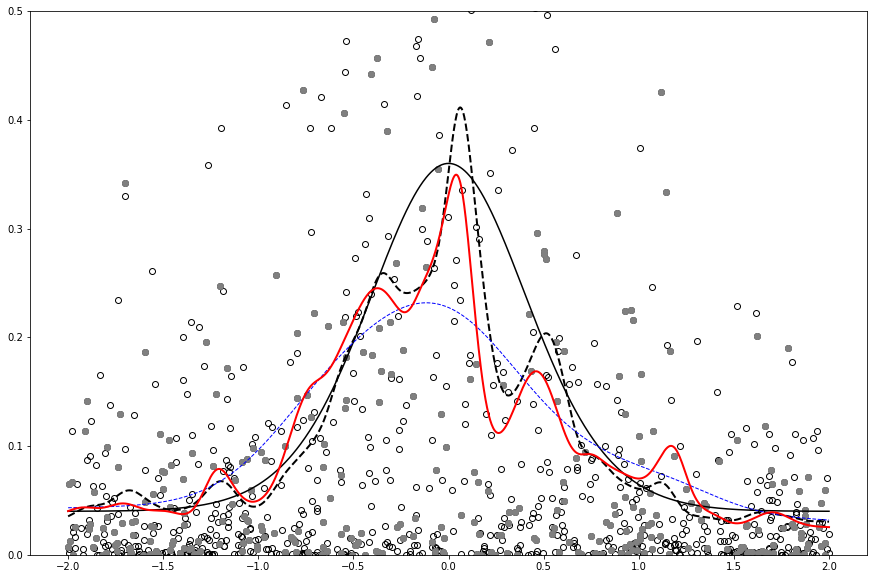

In [63]:
fig, ax = plt.subplots(1, 1,figsize=(15, 10))

plt.plot(df['x'],df['res_sqr'],'o',mfc='none',color='black')

plt.plot(df_cc['x'],df_cc['res_sqr'],'o',color='grey')

#Truth
ax.plot(np.linspace(-2, 2, n),sigma_reg(np.linspace(-2, 2, n),n)**2, color='black',markersize=3)

#Full
ax.plot(np.linspace(-2, 2, n),model_var.fit(np.linspace(-2, 2, n))[0] ,color= 'black', lw=2,linestyle='dashed')

#Complete-case 
ax.plot(np.linspace(-2, 2, n) ,model_var_cc.fit(np.linspace(-2, 2, n))[0] ,color= 'blue', lw=1,linestyle='dashed')

#IPW
ax.plot(np.linspace(-2, 2, n),[sigma_mis_res(h_ipw_var,t,X,df.res_sqr,pi(y,b0,b1),omega)**2 for t in np.linspace(-2, 2, n)],'-g',color= 'red', lw=2)

ax.set_ylim(0,0.5)